In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%matplotlib inline

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.initializers import RandomUniform
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
# import tensorflow as tf; tf.Session(config=tf.ConfigProto(log_device_placement=True))

import nengo
from lmu import LMUCell

Using TensorFlow backend.


In [4]:
import collections

def mackey_glass(sample_len=1000, tau=17, delta_t=10, seed=None, n_samples=1):
    # Adapted from https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples


def generate_data(n_batches, length, split=0.5, seed=0,
                  predict_length=15, tau=17, washout=100, delta_t=1,
                  center=True):
    X = np.asarray(mackey_glass(
        sample_len=length+predict_length+washout, tau=tau,
        seed=seed, n_samples=n_batches))
    X = X[:, washout:, :]
    cutoff = int(split*n_batches)
    if center:
        X -= np.mean(X)  # global mean over all batches, approx -0.066
    Y = X[:, predict_length:, :]
    X = X[:, :-predict_length, :]
    assert X.shape == Y.shape
    return ((X[:cutoff], Y[:cutoff]),
            (X[cutoff:], Y[cutoff:]))

In [5]:
(train_X, train_Y), (test_X, test_Y) = generate_data(128, 5000)
print(train_X.shape, test_X.shape)

(64, 5000, 1) (64, 5000, 1)


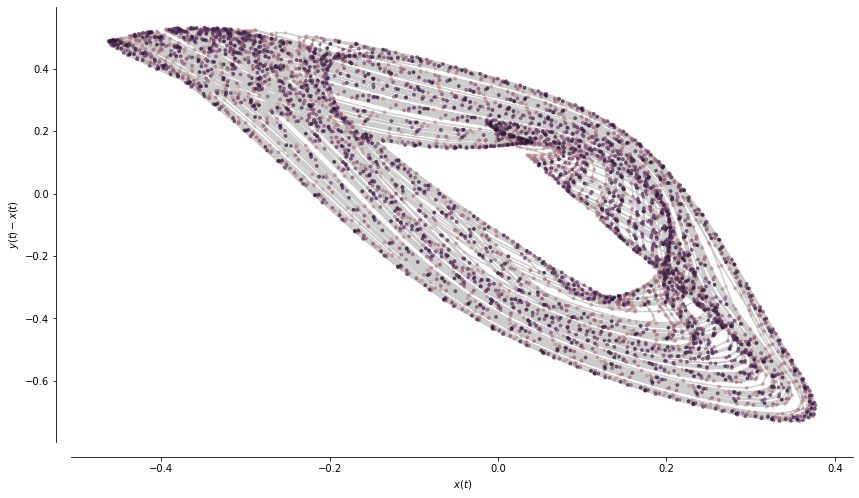

In [6]:
def cool_plot(X, Y, title=""):
    plt.figure(figsize=(14, 8))
    plt.title(title)
    plt.scatter(X[:, 0], Y[:, 0] - X[:, 0], s=8, alpha=0.7,
                c=np.arange(X.shape[0]), cmap=sns.cubehelix_palette(as_cmap=True))
    plt.plot(X[:, 0], Y[:, 0] - X[:, 0], c='black', alpha=0.2)
    plt.xlabel("$x(t)$")
    plt.ylabel("$y(t) - x(t)$")
    sns.despine(offset=15)
    
    plt.show()

cool_plot(train_X[0], train_Y[0])

In [7]:
def make_lstm(units, layers):
    model = Sequential()
    model.add(LSTM(units,
                   input_shape=(train_X.shape[1], 1),  # (timesteps, input_dims)
                   return_sequences=True))  # continuously outputs per timestep
    for _ in range(layers-1):
        model.add(LSTM(units, return_sequences=True))
    model.add(Dense(train_X.shape[-1], activation='tanh'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model


def delay_layer(units, **kwargs):
    return RNN(LMUCell(units=units,
                       order=4,
                       theta=4,
                       hidden_kernel_initializer='uniform',
                       include_bias=True,
                      ),
               return_sequences=True,
               **kwargs)


def make_lmu(units, layers):
    model = Sequential()
    model.add(delay_layer(units,
                          input_shape=(train_X.shape[1], 1)))  # (timesteps, input_dims)
    for _ in range(layers-1):
        model.add(delay_layer(units))
    model.add(Dense(train_X.shape[-1], activation='linear'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    
    return model


def make_hybrid(units_lstm, units_lmu, layers):
    assert layers == 4, "unsupported"
    model = Sequential()
    model.add(delay_layer(units=units_lmu,input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=units_lstm, return_sequences=True))
    model.add(delay_layer(units=units_lmu))
    model.add(LSTM(units=units_lstm, return_sequences=True))
    model.add(Dense(train_X.shape[-1], activation='tanh'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model


layers = 4
lstm_model = make_lstm(units=25, layers=layers)
lmu_model = make_lmu(units=49, layers=layers) 
hybrid_model = make_hybrid(units_lstm=25, units_lmu=40, layers=layers)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5000, 25)          2700      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5000, 25)          5100      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5000, 25)          5100      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5000, 25)          5100      
_________________________________________________________________
dense_1 (Dense)              (None, 5000, 1)           26        
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_____________

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from tempfile import mktemp

import time                     

def fit(model, fname):
    #_tname = mktemp(suffix=".hdf5")
    callbacks = [#EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20),
                 ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)]
    
    start = time.time()
    epochs = 500
    result = model.fit(
        train_X, train_Y, batch_size=32,
        epochs=epochs, callbacks=callbacks, validation_split=0.5)
    model.load_weights(fname)  # load best weights
    return result, (time.time() - start) / epochs

In [9]:
lmu_history, lmu_time = fit(
    lmu_model, "../models/lmu-mackey-glass.hdf5")


Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 7s 225ms/step - loss: 0.0601 - val_loss: 0.0262

Epoch 00001: val_loss improved from inf to 0.02624, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 5s 168ms/step - loss: 0.0263 - val_loss: 0.0259

Epoch 00002: val_loss improved from 0.02624 to 0.02587, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 3/500
32/32 [==============================] - 5s 167ms/step - loss: 0.0260 - val_loss: 0.0314

Epoch 00003: val_loss did not improve from 0.02587
Epoch 4/500
32/32 [==============================] - 5s 169ms/step - loss: 0.0315 - val_loss: 0.0221

Epoch 00004: val_loss improved from 0.02587 to 0.02207, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 5/500
32/32 [==============================] - 5s 169ms/step - loss: 0.0222 - val_loss: 0.0141

Epoch 00005: val_loss improved from 0.02207 to 0.01411, saving model to ../models/lmu-

32/32 [==============================] - 6s 183ms/step - loss: 0.0087 - val_loss: 0.0083

Epoch 00044: val_loss improved from 0.00864 to 0.00825, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 45/500
32/32 [==============================] - 5s 166ms/step - loss: 0.0083 - val_loss: 0.0078

Epoch 00045: val_loss improved from 0.00825 to 0.00780, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 46/500
32/32 [==============================] - 5s 168ms/step - loss: 0.0079 - val_loss: 0.0072

Epoch 00046: val_loss improved from 0.00780 to 0.00723, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 47/500
32/32 [==============================] - 5s 169ms/step - loss: 0.0073 - val_loss: 0.0067

Epoch 00047: val_loss improved from 0.00723 to 0.00672, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 48/500
32/32 [==============================] - 5s 168ms/step - loss: 0.0068 - val_loss: 0.0061

Epoch 00048: val_loss improved from 0.00672 to 0.00614, saving model to ../models/


Epoch 00085: val_loss improved from 0.00176 to 0.00175, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 86/500
32/32 [==============================] - 6s 179ms/step - loss: 0.0018 - val_loss: 0.0017

Epoch 00086: val_loss improved from 0.00175 to 0.00172, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 87/500
32/32 [==============================] - 5s 165ms/step - loss: 0.0017 - val_loss: 0.0017

Epoch 00087: val_loss improved from 0.00172 to 0.00170, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 88/500
32/32 [==============================] - 6s 173ms/step - loss: 0.0017 - val_loss: 0.0017

Epoch 00088: val_loss improved from 0.00170 to 0.00167, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 89/500
32/32 [==============================] - 5s 165ms/step - loss: 0.0017 - val_loss: 0.0017

Epoch 00089: val_loss improved from 0.00167 to 0.00166, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 90/500
32/32 [==============================] - 5s 166ms/step

32/32 [==============================] - 5s 164ms/step - loss: 0.0013 - val_loss: 0.0012

Epoch 00125: val_loss improved from 0.00124 to 0.00123, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 126/500
32/32 [==============================] - 5s 172ms/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00126: val_loss improved from 0.00123 to 0.00122, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 127/500
32/32 [==============================] - 6s 176ms/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00127: val_loss improved from 0.00122 to 0.00121, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 128/500
32/32 [==============================] - 5s 168ms/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00128: val_loss improved from 0.00121 to 0.00121, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 129/500
32/32 [==============================] - 5s 165ms/step - loss: 0.0012 - val_loss: 0.0012

Epoch 00129: val_loss improved from 0.00121 to 0.00120, saving model to ../mod


Epoch 00166: val_loss did not improve from 0.00101
Epoch 167/500
32/32 [==============================] - 5s 163ms/step - loss: 0.0015 - val_loss: 0.0013

Epoch 00167: val_loss did not improve from 0.00101
Epoch 168/500
32/32 [==============================] - 5s 165ms/step - loss: 0.0013 - val_loss: 9.4115e-04

Epoch 00168: val_loss improved from 0.00101 to 0.00094, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 169/500
32/32 [==============================] - 5s 164ms/step - loss: 9.5269e-04 - val_loss: 0.0012

Epoch 00169: val_loss did not improve from 0.00094
Epoch 170/500
32/32 [==============================] - 5s 165ms/step - loss: 0.0012 - val_loss: 0.0013

Epoch 00170: val_loss did not improve from 0.00094
Epoch 171/500
32/32 [==============================] - 5s 165ms/step - loss: 0.0013 - val_loss: 9.7167e-04

Epoch 00171: val_loss did not improve from 0.00094
Epoch 172/500
32/32 [==============================] - 5s 164ms/step - loss: 9.8459e-04 - val_loss: 9.7957e-

32/32 [==============================] - 5s 163ms/step - loss: 6.6131e-04 - val_loss: 6.3859e-04

Epoch 00211: val_loss improved from 0.00065 to 0.00064, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 212/500
32/32 [==============================] - 5s 163ms/step - loss: 6.4705e-04 - val_loss: 6.2943e-04

Epoch 00212: val_loss improved from 0.00064 to 0.00063, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 213/500
32/32 [==============================] - 5s 163ms/step - loss: 6.3790e-04 - val_loss: 6.2493e-04

Epoch 00213: val_loss improved from 0.00063 to 0.00062, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 214/500
32/32 [==============================] - 5s 162ms/step - loss: 6.3366e-04 - val_loss: 6.2117e-04

Epoch 00214: val_loss improved from 0.00062 to 0.00062, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 215/500
32/32 [==============================] - 5s 163ms/step - loss: 6.2918e-04 - val_loss: 6.1232e-04

Epoch 00215: val_loss improved from 0.


Epoch 00254: val_loss did not improve from 0.00036
Epoch 255/500
32/32 [==============================] - 5s 164ms/step - loss: 4.6574e-04 - val_loss: 4.7570e-04

Epoch 00255: val_loss did not improve from 0.00036
Epoch 256/500
32/32 [==============================] - 5s 163ms/step - loss: 4.8344e-04 - val_loss: 3.6440e-04

Epoch 00256: val_loss did not improve from 0.00036
Epoch 257/500
32/32 [==============================] - 5s 163ms/step - loss: 3.7013e-04 - val_loss: 3.3891e-04

Epoch 00257: val_loss improved from 0.00036 to 0.00034, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 258/500
32/32 [==============================] - 5s 163ms/step - loss: 3.4472e-04 - val_loss: 4.0858e-04

Epoch 00258: val_loss did not improve from 0.00034
Epoch 259/500
32/32 [==============================] - 5s 163ms/step - loss: 4.1567e-04 - val_loss: 4.0340e-04

Epoch 00259: val_loss did not improve from 0.00034
Epoch 260/500
32/32 [==============================] - 5s 163ms/step - loss: 4.0

32/32 [==============================] - 5s 163ms/step - loss: 2.1473e-04 - val_loss: 2.0823e-04

Epoch 00299: val_loss improved from 0.00021 to 0.00021, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 300/500
32/32 [==============================] - 5s 162ms/step - loss: 2.1322e-04 - val_loss: 2.0699e-04

Epoch 00300: val_loss improved from 0.00021 to 0.00021, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 301/500
32/32 [==============================] - 5s 162ms/step - loss: 2.1234e-04 - val_loss: 2.0714e-04

Epoch 00301: val_loss did not improve from 0.00021
Epoch 302/500
32/32 [==============================] - 5s 163ms/step - loss: 2.1212e-04 - val_loss: 2.0772e-04

Epoch 00302: val_loss did not improve from 0.00021
Epoch 303/500
32/32 [==============================] - 5s 163ms/step - loss: 2.1312e-04 - val_loss: 2.1098e-04

Epoch 00303: val_loss did not improve from 0.00021
Epoch 304/500
32/32 [==============================] - 5s 163ms/step - loss: 2.1590e-04 - val


Epoch 00346: val_loss did not improve from 0.00017
Epoch 347/500
32/32 [==============================] - 5s 163ms/step - loss: 1.9008e-04 - val_loss: 1.8905e-04

Epoch 00347: val_loss did not improve from 0.00017
Epoch 348/500
32/32 [==============================] - 5s 163ms/step - loss: 1.9446e-04 - val_loss: 1.7365e-04

Epoch 00348: val_loss did not improve from 0.00017
Epoch 349/500
32/32 [==============================] - 5s 164ms/step - loss: 1.7957e-04 - val_loss: 1.6299e-04

Epoch 00349: val_loss improved from 0.00017 to 0.00016, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 350/500
32/32 [==============================] - 5s 165ms/step - loss: 1.6869e-04 - val_loss: 1.6952e-04

Epoch 00350: val_loss did not improve from 0.00016
Epoch 351/500
32/32 [==============================] - 5s 163ms/step - loss: 1.7510e-04 - val_loss: 1.7792e-04

Epoch 00351: val_loss did not improve from 0.00016
Epoch 352/500
32/32 [==============================] - 5s 166ms/step - loss: 1.8

32/32 [==============================] - 5s 164ms/step - loss: 1.4670e-04 - val_loss: 1.4011e-04

Epoch 00390: val_loss improved from 0.00014 to 0.00014, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 391/500
32/32 [==============================] - 5s 164ms/step - loss: 1.4613e-04 - val_loss: 1.3967e-04

Epoch 00391: val_loss improved from 0.00014 to 0.00014, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 392/500
32/32 [==============================] - 5s 164ms/step - loss: 1.4570e-04 - val_loss: 1.3929e-04

Epoch 00392: val_loss improved from 0.00014 to 0.00014, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 393/500
32/32 [==============================] - 5s 163ms/step - loss: 1.4537e-04 - val_loss: 1.3903e-04

Epoch 00393: val_loss improved from 0.00014 to 0.00014, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 394/500
32/32 [==============================] - 5s 164ms/step - loss: 1.4506e-04 - val_loss: 1.3863e-04

Epoch 00394: val_loss improved from 0.

32/32 [==============================] - 5s 164ms/step - loss: 1.8199e-04 - val_loss: 6.3521e-04

Epoch 00432: val_loss did not improve from 0.00013
Epoch 433/500
32/32 [==============================] - 5s 163ms/step - loss: 6.4403e-04 - val_loss: 9.6176e-04

Epoch 00433: val_loss did not improve from 0.00013
Epoch 434/500
32/32 [==============================] - 5s 163ms/step - loss: 9.6739e-04 - val_loss: 6.8543e-04

Epoch 00434: val_loss did not improve from 0.00013
Epoch 435/500
32/32 [==============================] - 5s 164ms/step - loss: 6.9478e-04 - val_loss: 1.7709e-04

Epoch 00435: val_loss did not improve from 0.00013
Epoch 436/500
32/32 [==============================] - 5s 165ms/step - loss: 1.8372e-04 - val_loss: 2.8370e-04

Epoch 00436: val_loss did not improve from 0.00013
Epoch 437/500
32/32 [==============================] - 5s 163ms/step - loss: 2.9001e-04 - val_loss: 6.5062e-04

Epoch 00437: val_loss did not improve from 0.00013
Epoch 438/500
32/32 [===============

32/32 [==============================] - 5s 164ms/step - loss: 1.2286e-04 - val_loss: 1.1925e-04

Epoch 00480: val_loss did not improve from 0.00012
Epoch 481/500
32/32 [==============================] - 5s 164ms/step - loss: 1.2593e-04 - val_loss: 1.2062e-04

Epoch 00481: val_loss did not improve from 0.00012
Epoch 482/500
32/32 [==============================] - 5s 164ms/step - loss: 1.2757e-04 - val_loss: 1.1722e-04

Epoch 00482: val_loss did not improve from 0.00012
Epoch 483/500
32/32 [==============================] - 5s 163ms/step - loss: 1.2393e-04 - val_loss: 1.1507e-04

Epoch 00483: val_loss improved from 0.00012 to 0.00012, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 484/500
32/32 [==============================] - 6s 172ms/step - loss: 1.2186e-04 - val_loss: 1.1700e-04

Epoch 00484: val_loss did not improve from 0.00012
Epoch 485/500
32/32 [==============================] - 6s 188ms/step - loss: 1.2391e-04 - val_loss: 1.1793e-04

Epoch 00485: val_loss did not impr

In [10]:
lstm_history, lstm_time = fit(
    lstm_model, "../models/lstm-mackey-glass.hdf5")

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 8s 235ms/step - loss: 0.0483 - val_loss: 0.0466

Epoch 00001: val_loss improved from inf to 0.04657, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 6s 176ms/step - loss: 0.0466 - val_loss: 0.0449

Epoch 00002: val_loss improved from 0.04657 to 0.04491, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 3/500
32/32 [==============================] - 6s 178ms/step - loss: 0.0449 - val_loss: 0.0433

Epoch 00003: val_loss improved from 0.04491 to 0.04326, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 6s 178ms/step - loss: 0.0433 - val_loss: 0.0416

Epoch 00004: val_loss improved from 0.04326 to 0.04157, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 5/500
32/32 [==============================] - 6s 188ms/step - loss: 0.0416 - val_loss: 0.0398

Epoch 00005: val_loss improved


Epoch 00041: val_loss improved from 0.00899 to 0.00877, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 42/500
32/32 [==============================] - 6s 182ms/step - loss: 0.0088 - val_loss: 0.0086

Epoch 00042: val_loss improved from 0.00877 to 0.00861, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 43/500
32/32 [==============================] - 6s 182ms/step - loss: 0.0087 - val_loss: 0.0085

Epoch 00043: val_loss improved from 0.00861 to 0.00849, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 44/500
32/32 [==============================] - 6s 181ms/step - loss: 0.0086 - val_loss: 0.0084

Epoch 00044: val_loss improved from 0.00849 to 0.00837, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 45/500
32/32 [==============================] - 6s 183ms/step - loss: 0.0084 - val_loss: 0.0082

Epoch 00045: val_loss improved from 0.00837 to 0.00825, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 46/500
32/32 [==============================] - 6s 183ms

32/32 [==============================] - 6s 186ms/step - loss: 0.0046 - val_loss: 0.0045

Epoch 00081: val_loss improved from 0.00453 to 0.00446, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 82/500
32/32 [==============================] - 6s 185ms/step - loss: 0.0045 - val_loss: 0.0044

Epoch 00082: val_loss improved from 0.00446 to 0.00438, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 83/500
32/32 [==============================] - 6s 185ms/step - loss: 0.0044 - val_loss: 0.0043

Epoch 00083: val_loss improved from 0.00438 to 0.00429, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 84/500
32/32 [==============================] - 6s 187ms/step - loss: 0.0043 - val_loss: 0.0042

Epoch 00084: val_loss improved from 0.00429 to 0.00418, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 85/500
32/32 [==============================] - 6s 185ms/step - loss: 0.0042 - val_loss: 0.0041

Epoch 00085: val_loss improved from 0.00418 to 0.00407, saving model to ../mod


Epoch 00123: val_loss improved from 0.00079 to 0.00071, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 124/500
32/32 [==============================] - 6s 187ms/step - loss: 7.2687e-04 - val_loss: 7.4488e-04

Epoch 00124: val_loss did not improve from 0.00071
Epoch 125/500
32/32 [==============================] - 6s 187ms/step - loss: 7.6215e-04 - val_loss: 6.8371e-04

Epoch 00125: val_loss improved from 0.00071 to 0.00068, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 126/500
32/32 [==============================] - 6s 187ms/step - loss: 6.9959e-04 - val_loss: 6.8206e-04

Epoch 00126: val_loss improved from 0.00068 to 0.00068, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 127/500
32/32 [==============================] - 6s 186ms/step - loss: 6.9785e-04 - val_loss: 6.8050e-04

Epoch 00127: val_loss improved from 0.00068 to 0.00068, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 128/500
32/32 [==============================] - 6s 187ms/step - loss: 6.9

32/32 [==============================] - 6s 189ms/step - loss: 4.0600e-04 - val_loss: 3.8753e-04

Epoch 00163: val_loss improved from 0.00039 to 0.00039, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 164/500
32/32 [==============================] - 6s 185ms/step - loss: 4.0269e-04 - val_loss: 3.8452e-04

Epoch 00164: val_loss improved from 0.00039 to 0.00038, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 165/500
32/32 [==============================] - 6s 188ms/step - loss: 3.9953e-04 - val_loss: 3.7995e-04

Epoch 00165: val_loss improved from 0.00038 to 0.00038, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 166/500
32/32 [==============================] - 6s 186ms/step - loss: 3.9500e-04 - val_loss: 3.7550e-04

Epoch 00166: val_loss improved from 0.00038 to 0.00038, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 167/500
32/32 [==============================] - 6s 188ms/step - loss: 3.9041e-04 - val_loss: 3.7229e-04

Epoch 00167: val_loss improved fro

32/32 [==============================] - 6s 187ms/step - loss: 2.9903e-04 - val_loss: 3.7645e-04

Epoch 00204: val_loss did not improve from 0.00029
Epoch 205/500
32/32 [==============================] - 6s 188ms/step - loss: 3.8901e-04 - val_loss: 4.0519e-04

Epoch 00205: val_loss did not improve from 0.00029
Epoch 206/500
32/32 [==============================] - 6s 186ms/step - loss: 4.1792e-04 - val_loss: 2.8416e-04

Epoch 00206: val_loss improved from 0.00029 to 0.00028, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 207/500
32/32 [==============================] - 6s 187ms/step - loss: 2.9682e-04 - val_loss: 3.3947e-04

Epoch 00207: val_loss did not improve from 0.00028
Epoch 208/500
32/32 [==============================] - 6s 187ms/step - loss: 3.5208e-04 - val_loss: 3.7057e-04

Epoch 00208: val_loss did not improve from 0.00028
Epoch 209/500
32/32 [==============================] - 6s 186ms/step - loss: 3.8327e-04 - val_loss: 2.7919e-04

Epoch 00209: val_loss improved fr

32/32 [==============================] - 6s 187ms/step - loss: 2.3741e-04 - val_loss: 2.2447e-04

Epoch 00249: val_loss improved from 0.00023 to 0.00022, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 250/500
32/32 [==============================] - 6s 185ms/step - loss: 2.3569e-04 - val_loss: 2.2468e-04

Epoch 00250: val_loss did not improve from 0.00022
Epoch 251/500
32/32 [==============================] - 6s 187ms/step - loss: 2.3588e-04 - val_loss: 2.2417e-04

Epoch 00251: val_loss improved from 0.00022 to 0.00022, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 252/500
32/32 [==============================] - 6s 187ms/step - loss: 2.3531e-04 - val_loss: 2.2204e-04

Epoch 00252: val_loss improved from 0.00022 to 0.00022, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 253/500
32/32 [==============================] - 6s 187ms/step - loss: 2.3317e-04 - val_loss: 2.2038e-04

Epoch 00253: val_loss improved from 0.00022 to 0.00022, saving model to ../models/lstm-m


Epoch 00287: val_loss did not improve from 0.00019
Epoch 288/500
32/32 [==============================] - 6s 187ms/step - loss: 2.0491e-04 - val_loss: 1.9548e-04

Epoch 00288: val_loss did not improve from 0.00019
Epoch 289/500
32/32 [==============================] - 6s 186ms/step - loss: 2.0575e-04 - val_loss: 1.9806e-04

Epoch 00289: val_loss did not improve from 0.00019
Epoch 290/500
32/32 [==============================] - 6s 187ms/step - loss: 2.0838e-04 - val_loss: 2.0510e-04

Epoch 00290: val_loss did not improve from 0.00019
Epoch 291/500
32/32 [==============================] - 6s 189ms/step - loss: 2.1530e-04 - val_loss: 2.2187e-04

Epoch 00291: val_loss did not improve from 0.00019
Epoch 292/500
32/32 [==============================] - 6s 186ms/step - loss: 2.3222e-04 - val_loss: 2.6425e-04

Epoch 00292: val_loss did not improve from 0.00019
Epoch 293/500
32/32 [==============================] - 6s 185ms/step - loss: 2.7434e-04 - val_loss: 3.6084e-04

Epoch 00293: val_loss


Epoch 00336: val_loss did not improve from 0.00018
Epoch 337/500
32/32 [==============================] - 6s 185ms/step - loss: 1.9881e-04 - val_loss: 1.8026e-04

Epoch 00337: val_loss improved from 0.00018 to 0.00018, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 338/500
32/32 [==============================] - 6s 186ms/step - loss: 1.9085e-04 - val_loss: 1.8485e-04

Epoch 00338: val_loss did not improve from 0.00018
Epoch 339/500
32/32 [==============================] - 6s 186ms/step - loss: 1.9543e-04 - val_loss: 1.8391e-04

Epoch 00339: val_loss did not improve from 0.00018
Epoch 340/500
32/32 [==============================] - 6s 186ms/step - loss: 1.9441e-04 - val_loss: 1.7918e-04

Epoch 00340: val_loss improved from 0.00018 to 0.00018, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 341/500
32/32 [==============================] - 6s 186ms/step - loss: 1.8970e-04 - val_loss: 1.8339e-04

Epoch 00341: val_loss did not improve from 0.00018
Epoch 342/500
32/32 [====


Epoch 00378: val_loss improved from 0.00017 to 0.00017, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 379/500
32/32 [==============================] - 6s 186ms/step - loss: 1.7638e-04 - val_loss: 1.6602e-04

Epoch 00379: val_loss improved from 0.00017 to 0.00017, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 380/500
32/32 [==============================] - 6s 185ms/step - loss: 1.7608e-04 - val_loss: 1.6563e-04

Epoch 00380: val_loss improved from 0.00017 to 0.00017, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 381/500
32/32 [==============================] - 6s 185ms/step - loss: 1.7568e-04 - val_loss: 1.6536e-04

Epoch 00381: val_loss improved from 0.00017 to 0.00017, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 382/500
32/32 [==============================] - 6s 186ms/step - loss: 1.7540e-04 - val_loss: 1.6514e-04

Epoch 00382: val_loss improved from 0.00017 to 0.00017, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 383/500
32/32 [=====


Epoch 00416: val_loss improved from 0.00016 to 0.00016, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 417/500
32/32 [==============================] - 6s 186ms/step - loss: 1.6624e-04 - val_loss: 1.5613e-04

Epoch 00417: val_loss improved from 0.00016 to 0.00016, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 418/500
32/32 [==============================] - 6s 186ms/step - loss: 1.6600e-04 - val_loss: 1.5590e-04

Epoch 00418: val_loss improved from 0.00016 to 0.00016, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 419/500
32/32 [==============================] - 6s 188ms/step - loss: 1.6577e-04 - val_loss: 1.5567e-04

Epoch 00419: val_loss improved from 0.00016 to 0.00016, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 420/500
32/32 [==============================] - 6s 186ms/step - loss: 1.6554e-04 - val_loss: 1.5545e-04

Epoch 00420: val_loss improved from 0.00016 to 0.00016, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 421/500
32/32 [=====


Epoch 00454: val_loss improved from 0.00015 to 0.00015, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 455/500
32/32 [==============================] - 6s 199ms/step - loss: 1.5816e-04 - val_loss: 1.4815e-04

Epoch 00455: val_loss improved from 0.00015 to 0.00015, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 456/500
32/32 [==============================] - 6s 190ms/step - loss: 1.5796e-04 - val_loss: 1.4796e-04

Epoch 00456: val_loss improved from 0.00015 to 0.00015, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 457/500
32/32 [==============================] - 6s 194ms/step - loss: 1.5777e-04 - val_loss: 1.4776e-04

Epoch 00457: val_loss improved from 0.00015 to 0.00015, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 458/500
32/32 [==============================] - 6s 188ms/step - loss: 1.5757e-04 - val_loss: 1.4757e-04

Epoch 00458: val_loss improved from 0.00015 to 0.00015, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 459/500
32/32 [=====

32/32 [==============================] - 6s 194ms/step - loss: 1.8568e-04 - val_loss: 4.5782e-04

Epoch 00498: val_loss did not improve from 0.00014
Epoch 499/500
32/32 [==============================] - 6s 198ms/step - loss: 4.6865e-04 - val_loss: 1.5963e-04

Epoch 00499: val_loss did not improve from 0.00014
Epoch 500/500
32/32 [==============================] - 6s 190ms/step - loss: 1.7047e-04 - val_loss: 3.8251e-04

Epoch 00500: val_loss did not improve from 0.00014


In [11]:
hybrid_history, hybrid_time = fit(
    hybrid_model, "../models/hybrid-mackey-glass.hdf5")

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 8s 245ms/step - loss: 0.0348 - val_loss: 0.0203

Epoch 00001: val_loss improved from inf to 0.02026, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 6s 184ms/step - loss: 0.0203 - val_loss: 0.0149

Epoch 00002: val_loss improved from 0.02026 to 0.01494, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 3/500
32/32 [==============================] - 6s 181ms/step - loss: 0.0150 - val_loss: 0.0134

Epoch 00003: val_loss improved from 0.01494 to 0.01339, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 6s 178ms/step - loss: 0.0135 - val_loss: 0.0115

Epoch 00004: val_loss improved from 0.01339 to 0.01147, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 5/500
32/32 [==============================] - 6s 176ms/step - loss: 0.0116 - val_loss: 0.0090

Epoch 00005: val_loss 

32/32 [==============================] - 6s 177ms/step - loss: 0.0015 - val_loss: 0.0014

Epoch 00042: val_loss improved from 0.00149 to 0.00144, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 43/500
32/32 [==============================] - 6s 184ms/step - loss: 0.0015 - val_loss: 0.0014

Epoch 00043: val_loss improved from 0.00144 to 0.00137, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 44/500
32/32 [==============================] - 6s 178ms/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00044: val_loss improved from 0.00137 to 0.00130, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 45/500
32/32 [==============================] - 6s 179ms/step - loss: 0.0013 - val_loss: 0.0012

Epoch 00045: val_loss improved from 0.00130 to 0.00125, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 46/500
32/32 [==============================] - 6s 185ms/step - loss: 0.0013 - val_loss: 0.0012

Epoch 00046: val_loss improved from 0.00125 to 0.00119, saving model t

32/32 [==============================] - 6s 179ms/step - loss: 3.5998e-04 - val_loss: 3.3834e-04

Epoch 00080: val_loss improved from 0.00034 to 0.00034, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 81/500
32/32 [==============================] - 6s 175ms/step - loss: 3.5775e-04 - val_loss: 3.3539e-04

Epoch 00081: val_loss improved from 0.00034 to 0.00034, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 82/500
32/32 [==============================] - 6s 178ms/step - loss: 3.5482e-04 - val_loss: 3.3143e-04

Epoch 00082: val_loss improved from 0.00034 to 0.00033, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 83/500
32/32 [==============================] - 6s 177ms/step - loss: 3.5082e-04 - val_loss: 3.2851e-04

Epoch 00083: val_loss improved from 0.00033 to 0.00033, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 84/500
32/32 [==============================] - 6s 176ms/step - loss: 3.4787e-04 - val_loss: 3.2563e-04

Epoch 00084: val_loss improved

32/32 [==============================] - 6s 176ms/step - loss: 2.7102e-04 - val_loss: 2.4974e-04

Epoch 00118: val_loss improved from 0.00025 to 0.00025, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 119/500
32/32 [==============================] - 6s 176ms/step - loss: 2.6935e-04 - val_loss: 2.4809e-04

Epoch 00119: val_loss improved from 0.00025 to 0.00025, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 120/500
32/32 [==============================] - 6s 177ms/step - loss: 2.6770e-04 - val_loss: 2.4647e-04

Epoch 00120: val_loss improved from 0.00025 to 0.00025, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 121/500
32/32 [==============================] - 6s 181ms/step - loss: 2.6607e-04 - val_loss: 2.4490e-04

Epoch 00121: val_loss improved from 0.00025 to 0.00024, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 122/500
32/32 [==============================] - 6s 182ms/step - loss: 2.6449e-04 - val_loss: 2.4332e-04

Epoch 00122: val_loss impr


Epoch 00155: val_loss improved from 0.00020 to 0.00020, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 156/500
32/32 [==============================] - 6s 177ms/step - loss: 2.2156e-04 - val_loss: 2.0135e-04

Epoch 00156: val_loss improved from 0.00020 to 0.00020, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 157/500
32/32 [==============================] - 6s 174ms/step - loss: 2.2057e-04 - val_loss: 2.0038e-04

Epoch 00157: val_loss improved from 0.00020 to 0.00020, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 158/500
32/32 [==============================] - 6s 176ms/step - loss: 2.1960e-04 - val_loss: 1.9943e-04

Epoch 00158: val_loss improved from 0.00020 to 0.00020, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 159/500
32/32 [==============================] - 6s 177ms/step - loss: 2.1864e-04 - val_loss: 1.9849e-04

Epoch 00159: val_loss improved from 0.00020 to 0.00020, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 160/500
32

32/32 [==============================] - 6s 177ms/step - loss: 1.9102e-04 - val_loss: 1.7139e-04

Epoch 00193: val_loss improved from 0.00017 to 0.00017, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 194/500
32/32 [==============================] - 6s 177ms/step - loss: 1.9031e-04 - val_loss: 1.7069e-04

Epoch 00194: val_loss improved from 0.00017 to 0.00017, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 195/500
32/32 [==============================] - 6s 175ms/step - loss: 1.8961e-04 - val_loss: 1.6999e-04

Epoch 00195: val_loss improved from 0.00017 to 0.00017, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 196/500
32/32 [==============================] - 6s 175ms/step - loss: 1.8890e-04 - val_loss: 1.6930e-04

Epoch 00196: val_loss improved from 0.00017 to 0.00017, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 197/500
32/32 [==============================] - 6s 173ms/step - loss: 1.8820e-04 - val_loss: 1.6861e-04

Epoch 00197: val_loss impr


Epoch 00230: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 231/500
32/32 [==============================] - 6s 180ms/step - loss: 1.6588e-04 - val_loss: 1.4666e-04

Epoch 00231: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 232/500
32/32 [==============================] - 6s 176ms/step - loss: 1.6526e-04 - val_loss: 1.4605e-04

Epoch 00232: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 233/500
32/32 [==============================] - 6s 184ms/step - loss: 1.6465e-04 - val_loss: 1.4545e-04

Epoch 00233: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 234/500
32/32 [==============================] - 6s 183ms/step - loss: 1.6403e-04 - val_loss: 1.4485e-04

Epoch 00234: val_loss improved from 0.00015 to 0.00014, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 235/500
32


Epoch 00271: val_loss did not improve from 0.00013
Epoch 272/500
32/32 [==============================] - 6s 175ms/step - loss: 1.6032e-04 - val_loss: 1.8808e-04

Epoch 00272: val_loss did not improve from 0.00013
Epoch 273/500
32/32 [==============================] - 6s 175ms/step - loss: 2.0620e-04 - val_loss: 1.4167e-04

Epoch 00273: val_loss did not improve from 0.00013
Epoch 274/500
32/32 [==============================] - 6s 178ms/step - loss: 1.6001e-04 - val_loss: 1.3879e-04

Epoch 00274: val_loss did not improve from 0.00013
Epoch 275/500
32/32 [==============================] - 6s 178ms/step - loss: 1.5707e-04 - val_loss: 1.7025e-04

Epoch 00275: val_loss did not improve from 0.00013
Epoch 276/500
32/32 [==============================] - 6s 176ms/step - loss: 1.8831e-04 - val_loss: 1.3342e-04

Epoch 00276: val_loss did not improve from 0.00013
Epoch 277/500
32/32 [==============================] - 6s 175ms/step - loss: 1.5164e-04 - val_loss: 1.3696e-04

Epoch 00277: val_loss


Epoch 00316: val_loss improved from 0.00011 to 0.00011, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 317/500
32/32 [==============================] - 6s 176ms/step - loss: 1.2904e-04 - val_loss: 1.1095e-04

Epoch 00317: val_loss improved from 0.00011 to 0.00011, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 318/500
32/32 [==============================] - 6s 174ms/step - loss: 1.2872e-04 - val_loss: 1.1100e-04

Epoch 00318: val_loss did not improve from 0.00011
Epoch 319/500
32/32 [==============================] - 6s 181ms/step - loss: 1.2878e-04 - val_loss: 1.1049e-04

Epoch 00319: val_loss improved from 0.00011 to 0.00011, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 320/500
32/32 [==============================] - 6s 175ms/step - loss: 1.2823e-04 - val_loss: 1.0989e-04

Epoch 00320: val_loss improved from 0.00011 to 0.00011, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 321/500
32/32 [==============================] - 6s 175ms/step - l


Epoch 00354: val_loss improved from 0.00010 to 0.00010, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 355/500
32/32 [==============================] - 6s 179ms/step - loss: 1.1767e-04 - val_loss: 1.0011e-04

Epoch 00355: val_loss improved from 0.00010 to 0.00010, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 356/500
32/32 [==============================] - 6s 177ms/step - loss: 1.1741e-04 - val_loss: 9.9877e-05

Epoch 00356: val_loss improved from 0.00010 to 0.00010, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 357/500
32/32 [==============================] - 6s 175ms/step - loss: 1.1716e-04 - val_loss: 9.9632e-05

Epoch 00357: val_loss improved from 0.00010 to 0.00010, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 358/500
32/32 [==============================] - 6s 180ms/step - loss: 1.1691e-04 - val_loss: 9.9390e-05

Epoch 00358: val_loss improved from 0.00010 to 0.00010, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 359/500
32

32/32 [==============================] - 6s 173ms/step - loss: 1.0917e-04 - val_loss: 9.2271e-05

Epoch 00392: val_loss improved from 0.00009 to 0.00009, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 393/500
32/32 [==============================] - 6s 173ms/step - loss: 1.0906e-04 - val_loss: 9.2295e-05

Epoch 00393: val_loss did not improve from 0.00009
Epoch 394/500
32/32 [==============================] - 6s 178ms/step - loss: 1.0906e-04 - val_loss: 9.2481e-05

Epoch 00394: val_loss did not improve from 0.00009
Epoch 395/500
32/32 [==============================] - 6s 177ms/step - loss: 1.0925e-04 - val_loss: 9.3167e-05

Epoch 00395: val_loss did not improve from 0.00009
Epoch 396/500
32/32 [==============================] - 6s 174ms/step - loss: 1.0989e-04 - val_loss: 9.4742e-05

Epoch 00396: val_loss did not improve from 0.00009
Epoch 397/500
32/32 [==============================] - 6s 175ms/step - loss: 1.1151e-04 - val_loss: 9.8590e-05

Epoch 00397: val_loss did not i


Epoch 00440: val_loss did not improve from 0.00009
Epoch 441/500
32/32 [==============================] - 6s 176ms/step - loss: 1.0424e-04 - val_loss: 8.6611e-05

Epoch 00441: val_loss improved from 0.00009 to 0.00009, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 442/500
32/32 [==============================] - 6s 178ms/step - loss: 1.0287e-04 - val_loss: 8.9103e-05

Epoch 00442: val_loss did not improve from 0.00009
Epoch 443/500
32/32 [==============================] - 6s 175ms/step - loss: 1.0531e-04 - val_loss: 8.8810e-05

Epoch 00443: val_loss did not improve from 0.00009
Epoch 444/500
32/32 [==============================] - 6s 174ms/step - loss: 1.0508e-04 - val_loss: 8.6274e-05

Epoch 00444: val_loss improved from 0.00009 to 0.00009, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 445/500
32/32 [==============================] - 6s 175ms/step - loss: 1.0250e-04 - val_loss: 8.6527e-05

Epoch 00445: val_loss did not improve from 0.00009
Epoch 446/500
32/32 [

32/32 [==============================] - 6s 177ms/step - loss: 9.7415e-05 - val_loss: 8.1528e-05

Epoch 00483: val_loss improved from 0.00008 to 0.00008, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 484/500
32/32 [==============================] - 6s 173ms/step - loss: 9.7308e-05 - val_loss: 8.1466e-05

Epoch 00484: val_loss improved from 0.00008 to 0.00008, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 485/500
32/32 [==============================] - 6s 175ms/step - loss: 9.7228e-05 - val_loss: 8.1367e-05

Epoch 00485: val_loss improved from 0.00008 to 0.00008, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 486/500
32/32 [==============================] - 6s 174ms/step - loss: 9.7123e-05 - val_loss: 8.1247e-05

Epoch 00486: val_loss improved from 0.00008 to 0.00008, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 487/500
32/32 [==============================] - 6s 174ms/step - loss: 9.6984e-05 - val_loss: 8.1117e-05

Epoch 00487: val_loss impr

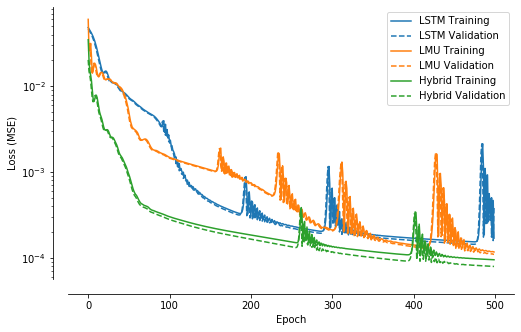

In [12]:
colors = sns.color_palette(None, 3)

plt.figure(figsize=(8, 5))
plt.plot(lstm_history.history['loss'], c=colors[0], label="LSTM Training")
plt.plot(lstm_history.history['val_loss'], c=colors[0], label="LSTM Validation", linestyle='--')

plt.plot(lmu_history.history['loss'], c=colors[1], label="LMU Training")
plt.plot(lmu_history.history['val_loss'], c=colors[1], label="LMU Validation", linestyle='--')

plt.plot(hybrid_history.history['loss'], c=colors[2], label="Hybrid Training")
plt.plot(hybrid_history.history['val_loss'], c=colors[2], label="Hybrid Validation", linestyle='--')

plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend()

sns.despine(offset=15)

plt.show()

In [13]:
print(lstm_time, lmu_time, hybrid_time)

6.010415269374848 5.348398925304413 5.723781653404236


In [14]:
lstm_Y = lstm_model.predict(test_X)
lmu_Y = lmu_model.predict(test_X)
hybrid_Y = hybrid_model.predict(test_X)

In [15]:
assert train_Y.shape[-1] == test_Y.shape[-1] == 1
print("LSTM", mean_squared_error(lstm_Y[:, :, 0], test_Y[:, :, 0]))
print("LMU", mean_squared_error(lmu_Y[:, :, 0], test_Y[:, :, 0]))
print("Hybrid", mean_squared_error(hybrid_Y[:, :, 0], test_Y[:, :, 0]))

LSTM 0.0001607573440884074
LMU 0.00011071360227590518
Hybrid 9.327362617014445e-05


In [16]:
from pandas import DataFrame
from collections import defaultdict
from nengolib.signal import nrmse

e_label = r'$\left(\hat{y}(t) - y(t)\right)^2$'

errors = defaultdict(list)
for name, pred_Y in (("LSTM", lstm_Y),
                     ("LMU", lmu_Y),
                     ("Hybrid", hybrid_Y),
                     ("Baseline", test_X)):
    print(name, "%.3f" % (100*nrmse(pred_Y.flatten(), target=test_Y.flatten())))
    
    for i in range(test_Y.shape[0]):
        for j in range(test_Y.shape[1]):
            errors[e_label].append((pred_Y[i, j, 0] - test_Y[i, j, 0])**2)
            errors['Time-step'].append(i)
            errors['Test'].append(j)
            errors['Method'].append(name)

LSTM 5.872
LMU 4.873
Hybrid 4.473
Baseline 162.400


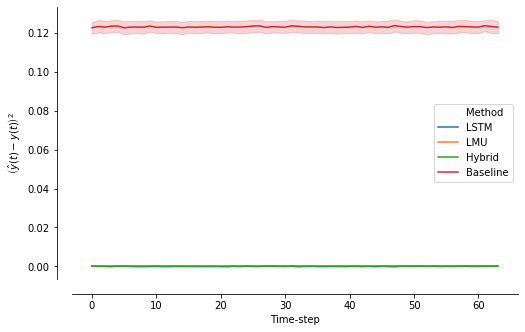

In [17]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=DataFrame(errors), x="Time-step", y=e_label, hue="Method")
#plt.xscale('log')
#plt.yscale('log')
sns.despine(offset=15)

plt.show()